In [1]:
import pandas as pd
import numpy as np
import csv
import time
from datetime import datetime

In [2]:
g=open('sales.csv',encoding='utf-8')
data=pd.read_csv(g)
g.close()

In [3]:
data.head()

,date,amount
0,2023/1/1,589
1,2023/1/2,561
2,2023/1/3,640
3,2023/1/4,656
4,2023/1/5,727


In [4]:
data.isnull().any()

date      False
amount    False
dtype: bool

In [5]:
len(data)

168

In [6]:
train=data[0:163]
test=data[163:168]

In [7]:
test

,date,amount
163,2023/6/13,858
164,2023/6/14,817
165,2023/6/15,827
166,2023/6/16,797
167,2023/6/17,843


In [8]:
train['date'] = pd.to_datetime(train['date'])  # 'date' 列を日時型に変換する
train.set_index(['date'], inplace=True)

C:\Users\awse\AppData\Local\Temp\ipykernel_13472\4292401529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = pd.to_datetime(train['date'])  # 'date' 列を日時型に変換する


In [9]:
len(train)

163

In [10]:
train.dtypes

amount    int64
dtype: object

In [11]:
train.head()

,amount
date,
2023-01-01,589
2023-01-02,561
2023-01-03,640
2023-01-04,656
2023-01-05,727


In [12]:
train.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2023-06-03', '2023-06-04', '2023-06-05', '2023-06-06',
               '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-10',
               '2023-06-11', '2023-06-12'],
              dtype='datetime64[ns]', name='date', length=163, freq=None)

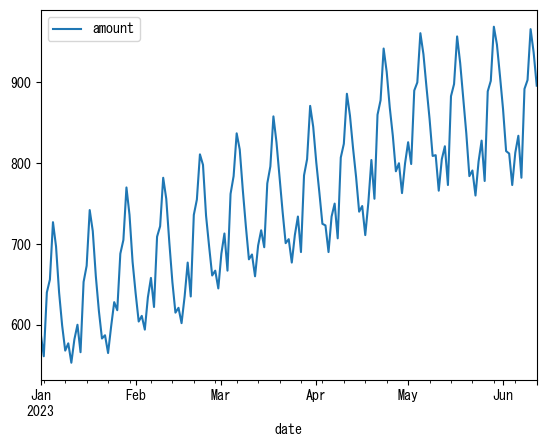

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['MS Gothic'] 
plt.rcParams['axes.unicode_minus'] = False 
train.plot()
plt.show()

C:\Users\awse\AppData\Local\Temp\ipykernel_13472\3025598522.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(train).show()


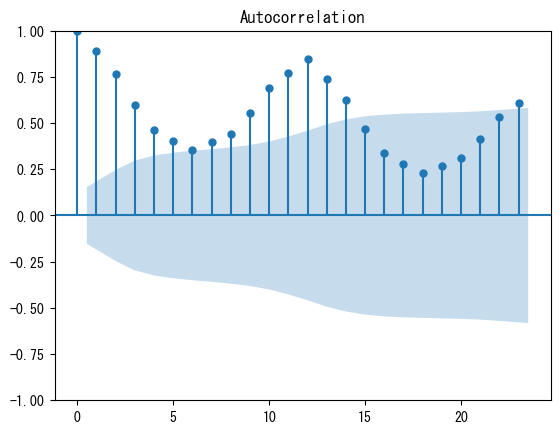

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train).show()

In [ ]:
from statsmodels.tsa.stattools import adfuller as ADF
print('元の系列のADF検定結果：',ADF(train['amount']))
#返し値は、adf、pvalue、usedlag、nobs、critical values、icbest、regresults、resstoreの順です。

元の系列のADF検定結果： (-1.7710319547121176, 0.3949353727419803, 13, 149, {'1%': -3.4750180242954167, '5%': -2.8811408028842043, '10%': -2.577221358046935}, 1076.6322847133642)


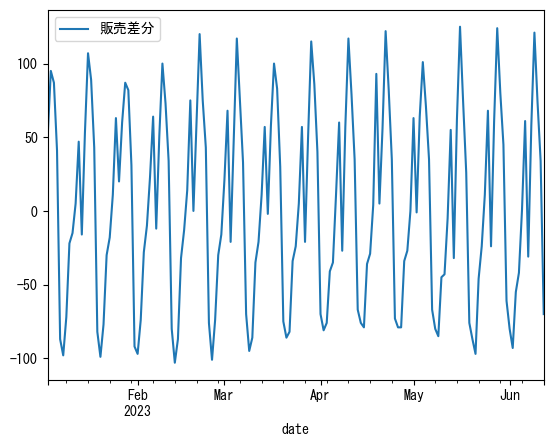

In [16]:
D_data = train.diff(2).dropna()
D_data.columns = ['販売差分']
D_data.plot() #時系列グラフ
plt.show()

C:\Users\awse\AppData\Local\Temp\ipykernel_13472\2538248294.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(D_data).show()


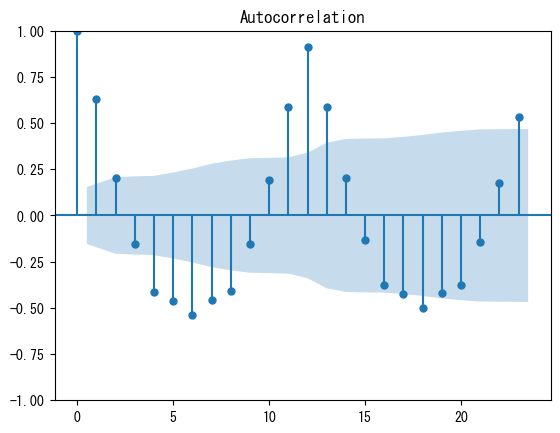

In [17]:
plot_acf(D_data).show()

C:\Users\awse\AppData\Local\Temp\ipykernel_13472\2140849780.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(D_data).show()


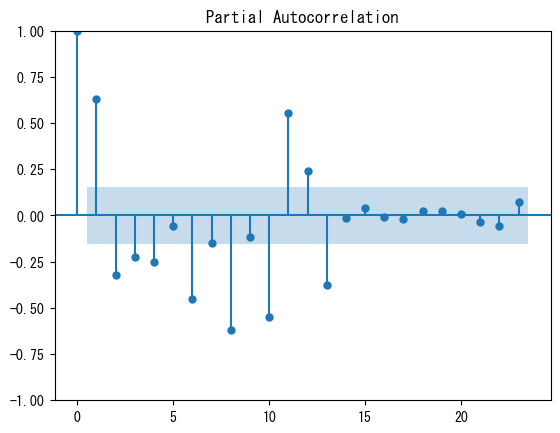

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(D_data).show()

In [19]:
print(u'差分系列のADF検定結果：', ADF(D_data[u'販売差分']))

差分系列のADF検定結果： (-2.2585899789621435, 0.18567139063736476, 11, 149, {'1%': -3.4750180242954167, '5%': -2.8811408028842043, '10%': -2.577221358046935}, 1063.353716376617)


ホワイトノイズ検定

In [20]:
#科学的記数法を無効にする
import sys
np.set_printoptions(suppress=True, threshold=sys.maxsize)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分系列のホワイトノイズ検定結果：', acorr_ljungbox(D_data, lags=1)) #統計量とp値を返します

差分系列のホワイトノイズ検定結果：     lb_stat     lb_pvalue
1  65.28097  6.494549e-16


In [23]:
from statsmodels.tsa.arima.model import ARIMA

train['amount'] = train['amount'].astype(float)
#階数を決定する
pmax = int(len(D_data)/20) 
qmax = int(len(D_data)/20) 
bic_matrix = [] #bic行列
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try: #一部のエラーが存在するため、tryを使用してエラーをスキップする。
            tmp.append(ARIMA(train, (p,2,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

bic_matrix = pd.DataFrame(bic_matrix) #最小値を見つける
#print(bic_matrix.dtypes)
bic_matrix = bic_matrix.apply(pd.to_numeric, errors='coerce')
# None値をnp.infに置き換える
bic_matrix = bic_matrix.fillna(np.inf)

p,q = bic_matrix.stack().idxmin() #まずstackを使って展開し、次にidxminで最小値の位置を見つける。
print(u'BICの最小のp値とq値：%s、%s' %(p,q)) 

BICの最小のp値とq値：0、0


C:\Users\awse\AppData\Local\Temp\ipykernel_13472\3454372808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['amount'] = train['amount'].astype(float)


In [24]:
train['amount']
print(train['amount'].shape)
print(train['amount'].dtype)

(163,)
float64


In [25]:
#train['amount'] = pd.to_numeric(train['amount'], errors='coerce').dropna()
model = ARIMA(train['amount'],order=(8,2,8)).fit() 
model.summary() #モデルを報告します

c:\Users\awse\anaconda3\envs\dataSci\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\awse\anaconda3\envs\dataSci\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\awse\anaconda3\envs\dataSci\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\awse\anaconda3\envs\dataSci\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 amount   No. Observations:                  163
Model:                 ARIMA(8, 2, 8)   Log Likelihood                -769.422
Date:                Wed, 05 Mar 2025   AIC                           1572.844
Time:                        21:57:54   BIC                           1625.228
Sample:                    01-01-2023   HQIC                          1594.114
                         - 06-12-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2950      1.604      0.184      0.854      -2.848       3.438
ar.L2          0.4039      1.070      0.377      0.706      -1.694       2.502
ar.L3         -0.6311      0.864     -0.731      0.465      -2.324       1.061
ar.L4         -0.7290      1.578     -0.462      0.644      -3.821       2.363
ar.L5          0.6504      0.846      0.769      0.442      -1.007       2.308
ar.L6         -0.2483      1.597     -0.155      0.876      -3.379       2.882
ar.L7         -0.3518      0.988     -0.356      0.722      -2.288       1.585
ar.L8         -0.3381      0.795     -0.426      0.670      -1.895       1.219
ma.L1         -1.8874      3.598     -0.525      0.600      -8.940       5.165
ma.L2          0.7988      8.162      0.098      0.922     -15.199      16.797
ma.L3          0.9338      4.832      0.193      0.847      -8.536      10.404
ma.L4         -0.3143      6.234     -0.050      0.960     -12.533      11.904
ma.L5         -1.5875     11.687     -0.136      0.892     -24.493      21.318
ma.L6          1.6686      7.599      0.220      0.826     -13.225      16.562
ma.L7         -0.4127      3.808     -0.108      0.914      -7.877       7.051
ma.L8         -0.1914      1.765     -0.108      0.914      -3.651       3.268
sigma2      1515.4297   5505.836      0.275      0.783   -9275.811    1.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 0.98
Prob(Q):                              0.54   Prob(JB):                         0.61
Heteroskedasticity (H):               1.03   Skew:                             0.06
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
model.forecast(5)

2023-06-13    868.129028
2023-06-14    781.308072
2023-06-15    798.754926
2023-06-16    762.161773
2023-06-17    783.804348
Freq: D, Name: predicted_mean, dtype: float64

In [27]:
test

,date,amount
163,2023/6/13,858
164,2023/6/14,817
165,2023/6/15,827
166,2023/6/16,797
167,2023/6/17,843


In [28]:
forecast=model.forecast(5)[0]

In [29]:
test['predict']=forecast

C:\Users\awse\AppData\Local\Temp\ipykernel_13472\1846431474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict']=forecast


In [30]:
test.head()

,date,amount,predict
163,2023/6/13,858,868.129028
164,2023/6/14,817,868.129028
165,2023/6/15,827,868.129028
166,2023/6/16,797,868.129028
167,2023/6/17,843,868.129028


In [31]:
def mape(x):
    a=x[1]
    b=x[2]
    result=abs(a-b)/a
    return  result

In [32]:
test['MAPE']=test.apply(mape,axis=1)

C:\Users\awse\AppData\Local\Temp\ipykernel_13472\3097466425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['MAPE']=test.apply(mape,axis=1)


In [33]:
test.head()

,date,amount,predict,MAPE
163,2023/6/13,858,868.129028,0.011805
164,2023/6/14,817,868.129028,0.062581
165,2023/6/15,827,868.129028,0.049733
166,2023/6/16,797,868.129028,0.089246
167,2023/6/17,843,868.129028,0.029809
